In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Conv2D, Convolution2DTranspose, BatchNormalization, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
from tensorflow.keras.datasets import mnist

In [4]:
def discriminator_model(in_shape=(28, 28, 1)):
    # Random Initial Weights from a Gaussian Distribution
    init = RandomNormal(stddev=0.02)
    # Define Model
    model = Sequential()
    # Downsample to 14x14
    model.add(Conv2D(64, (4, 4), strides=(2, 2), padding="same", kernel_initializer=init, input_shape=in_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # Downsample to 7x7
    model.add(Conv2D(64, (4, 4), strides=(2, 2), padding="same", kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # Classifier
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # Compile
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model


def generator_model(latent_dimension):
    # Random initial weights
    init = RandomNormal(stddev=0.02)
    # Define model
    model = Sequential()
    # Foundation for 7x7 image
    n_nodes = 128*7*7
    model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dimension))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # Upsample to 14x14
    model.add(Convolution2DTranspose(128, (4, 4), strides=(2, 2), padding="same", kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # Upsample to 28x28 image
    model.add(Convolution2DTranspose(128, (4, 4), strides=(2, 2), padding="same", kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # Output
    model.add(Conv2D(1, (7, 7), activation='tanh', padding='same', kernel_initializer=init))
    return model


def GAN(generator, discriminator):
    # Make weights in the discriminator not trainable
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


def load_real_samples():
    # Load Dataset
    (train_X, train_y), (_, _) = mnist.load_data()
    # Expand to 3D, e.g, add channels
    X = np.expand_dims(train_X, axis=-1)
    # Select only samples for only the symbol "8", short technique to get only preferred labels
    selected_sym = train_y == 8
    X = X[selected_sym]
    # Convert from ints to floats
    X = X.astype('float32')
    # Scale from [0, 255] to [-1, 1]
    X = (X - 127.5)/127.5
    return X


def generate_real_samples(dataset, n_samples):
    # Choose Random Instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    # Generate Class Labels
    y = np.ones((n_samples, 1))
    return X, y


def generate_latent_points(latent_dimension, n_samples):
    # Generate Points in the latent space
    x_input = np.random.randn(latent_dimension*n_samples)
    # Reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dimension)
    return x_input


def generate_fake_samples(generator, latent_dimension, n_samples):
    # Generate points in the latent space
    x_input = generate_latent_points(latent_dimension=latent_dimension, n_samples=n_samples)
    # Predict Outputs
    X = generator.predict(x_input)
    # Create Class Labels
    y = np.zeros((n_samples, 1))
    return X, y


def summarize_performance(step, generator, latent_dimension, n_samples=100):
    # Prepare Fake Samples
    X, _ = generate_fake_samples(
        generator=generator, latent_dimension=latent_dimension, n_samples=n_samples)
    # Scale from [-1, 1] to [0, 1]
    X = (X + 1)/2.0
    # Plot Images
    for i in range(10*10):
        # Define Subplot
        plt.subplot(10, 10, 1+i)
        # Turn off axis
        plt.axis('off')
        # Plot Raw Pixel data
        plt.imshow(X[i, :, :, 0], cmap='gray_r')
    # Save plot to file
    plt.savefig('results_baseline/generated_plot_%03d.png' % (step + 1))
    plt.close()
    # Save the model
    generator.save('results_baseline/model_%03d.h5' % (step + 1))


def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
    # Plot Loss
    plt.subplot(2, 1, 1)
    plt.plot(d1_hist, label='d-real')
    plt.plot(d2_hist, label='d-fake')
    plt.plot(g_hist, label='gen')
    plt.legend()
    # Plot discriminator accuracy
    plt.subplot(2, 1, 2)
    plt.plot(a1_hist, label='acc-real')
    plt.plot(a2_hist, label='acc-fake')
    plt.legend()
    # Save plot
    plt.savefig('results_baseline/plot_line_plot_loss.png')
    plt.close()


def train(generator, discriminator, gan, dataset, latent_dimension, n_epochs=10, n_batch=128):
    # Calculate the number of batches per epoch
    batch_per_epoch = int(dataset.shape[0] / n_batch)
    # Calculate total iterations based on batch and epoch
    n_steps = batch_per_epoch * n_epochs
    # Calculate number of samples in half a batch
    half_batch = int(n_batch/2)
    # Prepare lists for storing statistics for each iteration
    d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()
    # Manually enumerate epochs
    for i in range(n_steps):
        # Get randomly selected 'real' images
        X_real, y_real = generate_real_samples(dataset=dataset, n_samples=half_batch)
        # Update discriminator model weights
        d_loss1, d_acc1 = discriminator.train_on_batch(X_real, y_real)
        # Generate 'fake' samples
        X_fake, y_fake = generate_fake_samples(generator=generator, latent_dimension=latent_dimension, n_samples=half_batch)
        # Update discriminator model weights
        d_loss2, d_acc2 = discriminator.train_on_batch(X_fake, y_fake)
        # Prepare points in latent space as input for the generator
        X_gan = generate_latent_points(latent_dimension=latent_dimension, n_samples=n_batch)
        # Create inverted labels for the fake samples
        y_gan = np.ones((n_batch, 1))
        # Update the generator via the discriminator's error
        g_loss = gan.train_on_batch(X_gan, y_gan)
        # Summarize loss on this batch
        print(f">{i+1}, d1={d_loss1:.3f}, d2={d_loss2:.3f}, g={g_loss:.3f}, a1={int(100*d_acc1)}, a2={int(100*d_acc2)}")
        d1_hist.append(d_loss1)
        d2_hist.append(d_loss2)
        g_hist.append(g_loss)
        a1_hist.append(d_acc1)
        a2_hist.append(d_acc2)
        # Evaluate the model performance after each epoch
        if (i+1) % batch_per_epoch == 0:
            summarize_performance(i, generator=generator, latent_dimension=latent_dimension)
    plot_history(d1_hist=d1_hist, d2_hist=d2_hist, g_hist=g_hist, a1_hist=a1_hist, a2_hist=a2_hist)


In [5]:
os.makedirs('results_baseline', exist_ok=True)
# Size of the latent space
latent_dimension = 50
# Create Discriminator and generator
discriminator = discriminator_model()
generator = generator_model(latent_dimension=latent_dimension)
gan_model = GAN(generator=generator, discriminator=discriminator)
dataset = load_real_samples()
train(generator=generator, discriminator=discriminator, gan=gan_model, dataset=dataset, latent_dimension=latent_dimension)

2/2 [==============================] - 0s 2ms/step
>1, d1=0.876, d2=0.792, g=0.693, a1=35, a2=25
2/2 [==============================] - 0s 4ms/step
>2, d1=0.187, d2=0.926, g=0.670, a1=100, a2=12
2/2 [==============================] - 0s 5ms/step
>3, d1=0.081, d2=0.873, g=0.663, a1=100, a2=31
2/2 [==============================] - 0s 6ms/step
>4, d1=0.061, d2=0.626, g=0.667, a1=100, a2=70
2/2 [==============================] - 0s 5ms/step
>5, d1=0.044, d2=0.336, g=0.669, a1=100, a2=98
2/2 [==============================] - 0s 5ms/step
>6, d1=0.041, d2=0.190, g=0.673, a1=100, a2=100
2/2 [==============================] - 0s 5ms/step
>7, d1=0.038, d2=0.130, g=0.676, a1=100, a2=100
2/2 [==============================] - 0s 5ms/step
>8, d1=0.028, d2=0.112, g=0.679, a1=100, a2=100
2/2 [==============================] - 0s 5ms/step
>9, d1=0.032, d2=0.101, g=0.679, a1=100, a2=100
2/2 [==============================] - 0s 5ms/step
>10, d1=0.029, d2=0.111, g=0.679, a1=100, a2=100
2/2 [==========

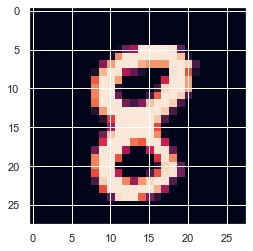

In [22]:
(train_X, train_y), (_, _) = mnist.load_data()
selected_sym = train_y == 8
selected_sym
X = train_X[selected_sym]
plt.imshow(X[180])